In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import pandas as pd
import os,os

In [8]:
mnist=tf.keras.datasets.mnist

In [9]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

In [10]:
X_train,X_test=X_train/255*2-1,X_test/255*2-1

In [8]:
N,H,W=X_train.shape

NameError: name 'X_train' is not defined

In [12]:
D=H*W
X_train=X_train.reshape(-1,D)
X_test=X_test.reshape(-1,D)

In [7]:
latent_dim=100

In [14]:
from tensorflow.keras.layers import Input, Dense,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD


In [15]:
def build_generator(latend_dim):
  i=Input(shape=(latent_dim,))
  X=Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  X=BatchNormalization(momentum=0.8)(X)
  X=Dense(512,activation=LeakyReLU(alpha=0.2))(X)
  X=BatchNormalization(momentum=0.8)(X)
  X=Dense(1024,activation=LeakyReLU(alpha=0.2))(X)
  X=BatchNormalization(momentum=0.8)(X)
  X=Dense(4096,activation=LeakyReLU(alpha=0.2))(X)
  X=BatchNormalization(momentum=0.8)(X)
  X=Dense(2048,activation=LeakyReLU(alpha=0.2))(X)
  X=BatchNormalization(momentum=0.8)(X)
  x=Dense(D,activation='tanh')(X)
  model=Model(i,x)
  return model

In [16]:
def build_discriminant(img_size):
  i=Input(shape=(img_size,))
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x=Dense(1,activation='sigmoid')(x)
  model=Model(i,x)
  return model

In [17]:
latent_dim

100

In [18]:
# latent_dim=(100,)
discrim=build_discriminant(D)
discrim.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5), metrics=['accuracy'])
gen=build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = gen(z)
discrim.trainable=False
validity = discrim(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [19]:
batch_size=32
epochs=38000
sample_period=200
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)
d_losses=[]
g_losses=[]
if not os.path.exists('gan_images_mnist'):
  os.makedirs('gan_images_mnist')


In [20]:
# In the file ipython-input-114-01221e716c20 or earlier, define latent_dim as a tuple:


def sample_images(epoch):
  rows,cols=5,5
  noise=np.random.randn(rows*cols,latent_dim) # Now latent_dim[0] will correctly access the first element
  imgs=gen.predict(noise)
  imgs=0.5*imgs+0.5
  fig,axs=plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx+=1
  fig.savefig(f'gan_images_mnist/{epoch}.png')
  plt.close()

In [21]:
sample_images(0)

1/1 [==============================] - 0s 287ms/step


In [22]:
for epoch in range(epochs):
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  real_imgs = X_train[idx]
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = gen.predict(noise)
  d_loss_real,dacc_real = discrim.train_on_batch(real_imgs, ones.reshape(-1, 1))
  d_loss_fake,dacc_fake = discrim.train_on_batch(fake_imgs, zeros.reshape(-1, 1))
  d_loss = 0.5 * (d_loss_real+d_loss_fake)
  d_acc = 0.5 * (dacc_real+dacc_fake)



  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined.train_on_batch(noise, ones.reshape(-1, 1))
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % sample_period == 0:
    print(f'epoch:{epoch}, d_loss: {d_loss}, d_acc: {d_acc}, g_loss: {g_loss}' )
  if epoch % sample_period == 0:
    sample_images(epoch)
  print(epoch)

1/1 [==============================] - 0s 39ms/step




epoch:0, d_loss: 0.5880943834781647, d_acc: 0.5, g_loss: 0.47494781017303467
1/1 [==============================] - 0s 29ms/step
0
1/1 [==============================] - 0s 24ms/step
1
1/1 [==============================] - 0s 23ms/step
2
1/1 [==============================] - 0s 28ms/step
3
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 31ms/step
5
1/1 [==============================] - 0s 31ms/step
6
1/1 [==============================] - 0s 23ms/step
7
1/1 [==============================] - 0s 22ms/step
8
1/1 [==============================] - 0s 23ms/step
9
1/1 [==============================] - 0s 23ms/step
10
1/1 [==============================] - 0s 21ms/step
11
1/1 [==============================] - 0s 21ms/step
12
1/1 [==============================] - 0s 25ms/step
13
1/1 [==============================] - 0s 31ms/step
14
1/1 [==============================] - 0s 25ms/step
15
1/1 [==============================] - 0s 22ms/step

In [24]:
import joblib
joblib.dump(gen,'gan_images/GAN_gen.pkl')
joblib.dump(discrim,'gan_images/GAN_discrim.pkl')
joblib.dump(combined,'gan_images/GAN_combined.pkl')

['gan_images/GAN_combined.pkl']

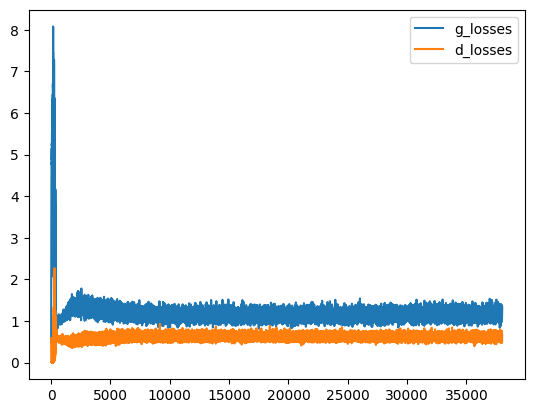

In [26]:
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')
plt.legend()
plt.show()

1/1 [==============================] - 0s 237ms/step


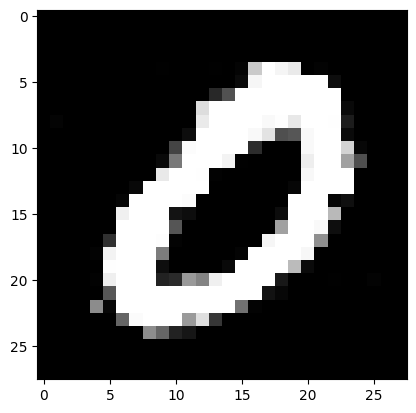

In [3]:
#predict new image using the generator and save it as newgen
import joblib
import numpy as np
import matplotlib.pyplot as plt

gen=joblib.load('gan_images_mnist/GAN_gen.pkl')
newgen=gen.predict(np.random.randn(1,100))
newgen=newgen.reshape(28,28)
#save newgen as newgen.png
plt.imshow(newgen,cmap='gray')

In [10]:
newgen

array([[-1.        , -1.        , -0.9996375 , -1.        , -1.        ,
        -0.9999986 , -0.99987364, -0.99992776, -0.9999993 , -0.99999636,
        -0.9999937 , -0.99996936, -0.9999915 , -0.99999744, -0.9999994 ,
        -0.998958  , -0.99999917, -0.9997978 , -0.9999871 , -0.9999894 ,
        -0.9999713 , -0.9999995 , -0.99998814, -0.99980134, -0.99988794,
        -0.9999975 , -0.99850047, -1.        , -1.        , -0.9999963 ,
        -0.9999948 , -0.9999511 , -1.        , -0.9966555 , -0.9947301 ,
        -1.        , -0.9963714 , -0.9999415 , -0.99999714, -0.9999986 ,
        -0.99998534, -1.        , -0.60136765, -0.9999844 , -0.99999744,
        -1.        , -0.99999964, -0.99999106, -0.9995571 , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.9999966 ,
        -0.9999998 , -0.99999714, -0.99993336, -0.9999706 , -1.        ,
        -1.        , -1.        , -0.99999106, -0.9999959 , -0.99991214,
        -0.9999998 , -0.9999996 , -0.9999998 , -1. 

In [8]:
!pip list --format=freeze > requirements.txt

In [5]:
!streamlit run BaseGanStreamlit.py

^C


In [4]:
import streamlit as st
import joblib
import numpy as np
from tensorflow import keras
#predict new image using the generator and save it as newgen
import matplotlib.pyplot as plt

# Load the generator model
gen = joblib.load('gan_images_mnist/GAN_gen.pkl')

# Generate a new image
generate=st.button('Generate New Image')
if generate:
    newgen = gen.predict(np.random.randn(1, 100))
    newgen = newgen.reshape(28, 28)

    # Display the new image using Streamlit
    # st.image(newgen, caption='Generated Image', use_column_width=True)
    
    generate=False

2024-08-20 23:22:26.619 
  command:

    streamlit run c:\Users\Swar Jagdale\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [11]:
import tensorflow as tf
tf.keras.models.save_model(gen,'gan_images_mnist/GAN_gen.h5')

C:\Users\Swar Jagdale\AppData\Local\Temp\ipykernel_39168\3736390175.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(gen,'gan_images_mnist/GAN_gen.h5')


1/1 [==============================] - 0s 93ms/step


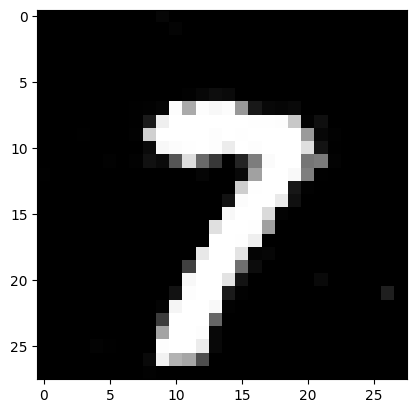

In [12]:
gen1=tf.keras.models.load_model('gan_images_mnist/GAN_gen.h5')
newgen1=gen1.predict(np.random.randn(1,100))
newgen1=newgen1.reshape(28,28)
plt.imshow(newgen1,cmap='gray')
